# OM data prepocessing

## About OM

 This code uses the processed images from XMM-Newton's **Opical Monitor**. The images are **diffraction-limited** and each of the 5 exposures per filter are sub-windows covering 92% of the 17'x17' FOV (*2048x2048* pixels). The windows are stacked (2048x2048) and rebinned to **512x512** for computational efficiency. 
 
 Information about the configuration of the OM (e.g.: sub-windows stacking) can be found here: https://www.mssl.ucl.ac.uk/www_xmm/ukos/onlines/uhb/XMM_UHB/node62.html

## Setup



In [1]:
import os
# !pip install astropy
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import numpy as np
from astropy.io import fits
from scipy.interpolate import interp1d
from astropy.visualization import ZScaleInterval, ImageNormalize
from scipy.signal import fftconvolve
import matplotlib.image as mpimg
from PIL import Image
from scipy.ndimage import gaussian_filter

# this is needed to reload changes from imported modules, without the need to restart the kernel
from importlib import reload
import preprocess_utils
reload(preprocess_utils)
from preprocess_utils import *

In [2]:
OM_dir =  "/workspace/raid/OM_DeepLearning/XMM_OM_dataset/scaled_raw_512/"
OM_dir

'/workspace/raid/OM_DeepLearning/XMM_OM_dataset/scaled_raw_512/'

# Optical Monitor images

Each of the 5 OM windows is a single exposure. Sometimes, these windows are not exactly superposed when stacked together. Thus, empty regions (black -ve pixels) appear and may affect the model prediction. There are 2 possible options here:

1. fill the missing pixels with a randomised distribution 
2. use the negative pixel map during model training, ussually in the following steps: 
	* following image pre-processing (e.g., normalization)
	* (otpional) when computing the loss (ignoring false predictions on negative masks)
	* for filtering output predictions

This notebook adresses the first option. However, in practice, it is hard to generate a distribution that would look natural on negative regions with big areas. Instead, both generating distributions for small negative areas and using the negative map to filter out predictions as in option 2 results in better predictions.

## Generating Gaussian distributions on negative pixel map

In [30]:
def fill_localised(input_array, distribution = 'poisson', size_input=2):
    """
    Fills all masked elements of an array with poisson/gaussian signal with local expected value.
    """
    array = np.ma.masked_less(input_array, 0)
   
    if not (isinstance(array, np.ma.MaskedArray)):
        print('No mask found')
        return input_array
    size = size_input
    output = array.data.copy()
    mask = array.mask.copy()
    mask_full = np.ones(mask.shape)
    
    # print(mask.sum())
    while mask.sum() > 1:
        kernel = np.ones((size, size))/size**2 # creates a kernel of ones with shape (size, size) normalized by size**2.
        coeff_full = fftconvolve(mask_full, kernel, mode='same')
        coeff = fftconvolve(np.logical_not(mask), kernel, mode='same') / coeff_full
        mean = fftconvolve(output, kernel, mode='same')
        
        # compute stdev
        diff = output - mean
        sq_diff = fftconvolve(diff**2, kernel, mode='same')
        sq_diff = np.clip(sq_diff, 0, None)
        std_dev = np.sqrt(sq_diff)
        norm_ = data_norm(mean[mean>=0])
        idx = np.where(np.logical_and(mask, coeff > 0.5))
        lambda_ = np.abs(mean[idx]/coeff[idx])
        std = np.abs(std_dev[idx]/coeff[idx])
        
        if distribution == 'poisson':
            output[idx] = np.abs(np.random.poisson(lambda_))
        if distribution == 'gaussian':
            output[idx] = np.abs(np.random.normal(lambda_, std))/8
        if distribution == 'thomas':
            mu = np.mean(mean)  # Compute mu from mean array
            output[idx] = thomas(mu, 1, 1, size=3183)
        mask[idx] = False
        size += size_input
        size += (1 - size % 2)
    norm_ = data_norm(output)
    plt.figure() 
    plt.imshow(output, cmap='gray', norm=norm_)
    plt.axis('off')
    plt.tight_layout(pad=0, w_pad=0, h_pad=0)
    plt.show()
    return output

In [31]:
# IMAGE_NAME = "/workspace/raid/OM_DeepLearning/XMM_OM_dataset/scaled_raw/S0103060201_S.fits"
# IMAGE_PATH = os.path.join(OM_dir,IMAGE_NAME)
# original_image = fits.open(IMAGE_PATH)[0].data
# output1 = fill_localised(original_image, 'gaussian')

In [32]:
def threshold_sigma(image_array, sigma_):

    print("Computing sigma thresholding only for on-zero pixel image array:")
    mean_value = np.mean(image_array)
    std_dev = np.std(image_array)
    threshold = mean_value + sigma_ * std_dev
    print("\u03BC =", mean_value, "\u03C3 =", std_dev, f", threshold: \u03BC + {sigma_} * \u03C3:", threshold)
    
    # Extract the values within "sigma_" standard deviation
    values_within_3_sigma = []
    for i in range(len(image_array)):
            if(image_array[i] < threshold):
                values_within_3_sigma.append(image_array[i])

    return values_within_3_sigma

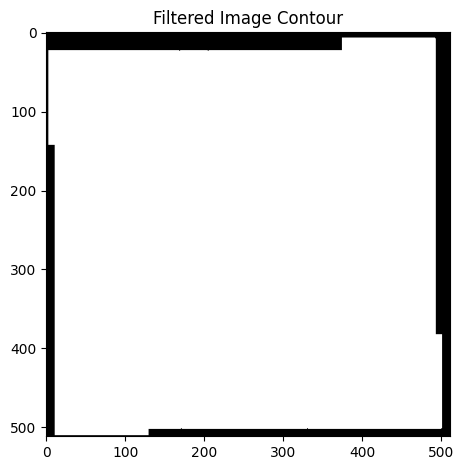

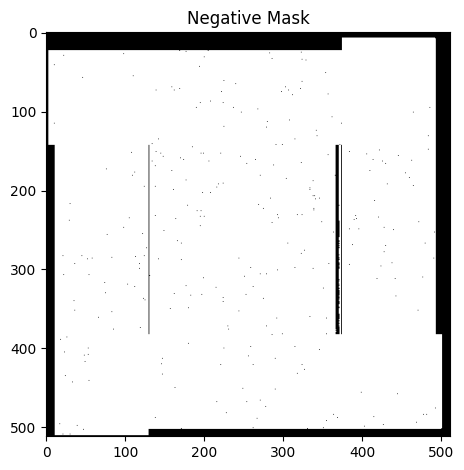

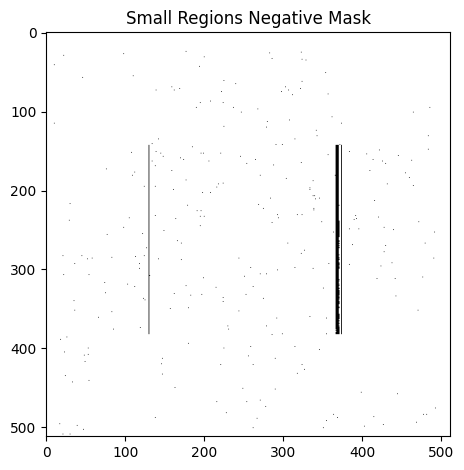

Fill missing data with distribution: 
Computing sigma thresholding only for on-zero pixel image array:
μ = 0.006683792 σ = 0.0620296 , threshold: μ + 1 * σ: 0.06871339213103056


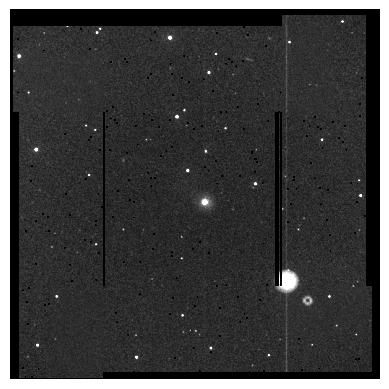

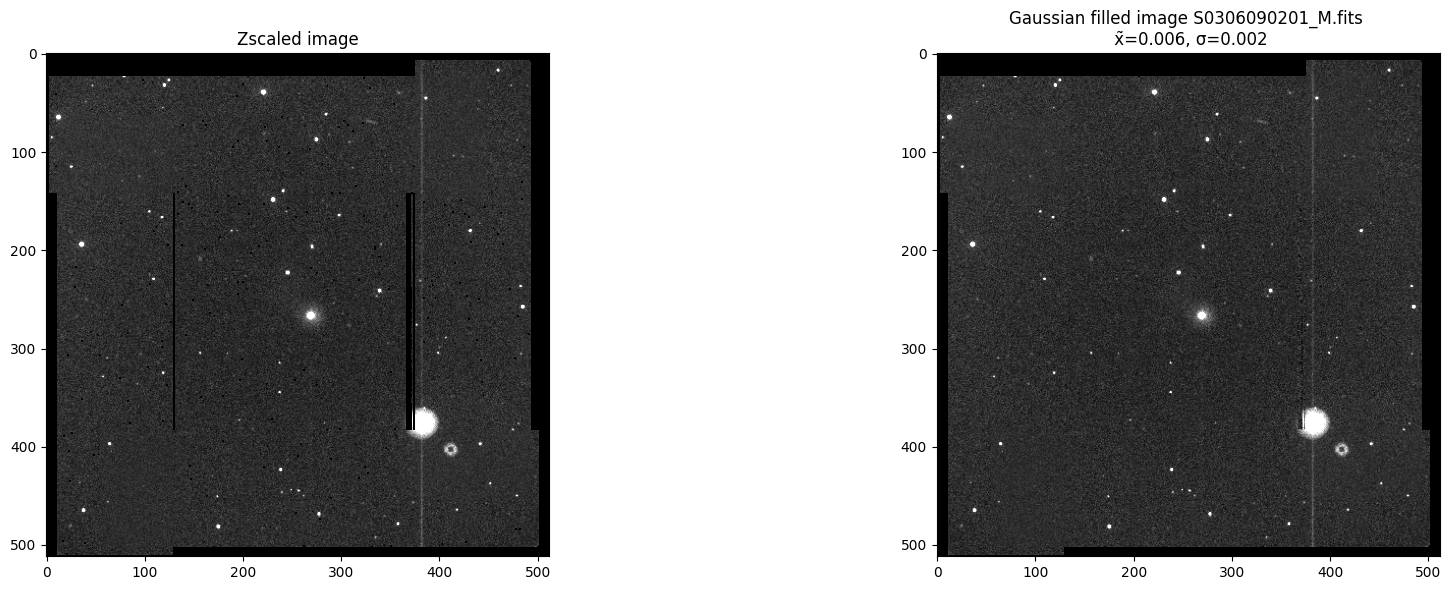

In [33]:
def fill_missing_data_with_distribution(fits_path, small_regions_negative_mask=None, seed=2):
    '''
    This selectively replaces certain values in an array with random values from a Gaussian distribution for the negative pixels.
    '''
    hdul = fits.open(fits_path)

    #apparently, I need to flip the matrix horizontally, otherwise the output is mirrored.
    fits_data = hdul[0].data.copy() 
    fits_data = np.flipud(fits_data)
    hdul.close()
    
    print("Fill missing data with distribution: ")
    # take only values at a sigma value (close to background) and non-zero
    valid_data = threshold_sigma(fits_data[fits_data>=0], sigma_ = 1)
    
    mu = np.median(valid_data)
    sigma = np.std(valid_data)
    generator = np.random.default_rng(0)
    filled_data = np.matrix(fits_data)
    num_rows, num_cols = filled_data.shape
    for i in range(num_rows):
        for j in range(num_cols):
            if(fits_data[i,j] <= 0) and small_regions_negative_mask[i,j]==0:
                filled_data[i,j] = np.abs(generator.normal(mu, sigma))
    return np.array(filled_data), mu, sigma

OM_dir= '/workspace/raid/OM_DeepLearning/XMM_OM_dataset/scaled_raw_512/'
imgs = ['S0306090201_M.fits']
for img_path in imgs:
    if img_path.endswith('.fits'):
        IMAGE_PATH = os.path.join(OM_dir,img_path)
        original_image = fits.open(IMAGE_PATH)[0].data.copy()
        original_image = np.flipud(original_image) # here flip the fits data
        image = cv2.imread(OM_dir+'S0306090201_M.png', cv2.IMREAD_GRAYSCALE)

        # find the negative mask
        negative_mask = (image > 0).astype(np.uint8) * 255
        # find big negative regions by finding image EXTERNAL contours 
        contours, _ = cv2.findContours(negative_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        filtered_image = np.zeros_like(image)
        for contour in contours:
            cv2.drawContours(filtered_image, [contour], -1, color=255, thickness=cv2.FILLED)

        # apply logical expr to get only black regions not in the countours 
        # NOT(A) * NOT(B) + A * B
        small_regions_negative_mask = np.logical_not(filtered_image).astype(int) * np.logical_not(negative_mask).astype(int) + filtered_image * negative_mask

        # fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        # axes[0].imshow(filtered_image, cmap='gray')
        # axes[0].set_title('Filtered Image Contour')
        # axes[1].imshow(negative_mask, cmap='gray')
        # axes[1].set_title('Negative Mask')
        # axes[2].imshow(small_regions_negative_mask, cmap='gray')
        # axes[2].set_title('Small Regions Negative Mask')
        # plt.tight_layout()
        # plt.savefig('./plots/gaussian_crowding.png')
        # plt.show()
        
        
        plt.imshow(filtered_image, cmap='gray')
        plt.title('Filtered Image Contour')
        plt.tight_layout()
        plt.savefig('./plots/img_contour.png', bbox_inches='tight', pad_inches=0) # Save with no padding
        plt.show()
        plt.close()
        plt.imshow(negative_mask, cmap='gray')
        plt.title('Negative Mask')
        plt.tight_layout()
        plt.savefig('./plots/neg_mask.png', bbox_inches='tight', pad_inches=0) # Save with no padding
        plt.show()
        plt.close()
        plt.imshow(small_regions_negative_mask, cmap='gray')
        plt.title('Small Regions Negative Mask')
        plt.tight_layout()
        plt.savefig('./plots/small_regions_mask.png', bbox_inches='tight', pad_inches=0) # Save with no padding
        plt.show()
        plt.close()

    
        # gaussian filtering
        modified_image, mu, sigma = fill_missing_data_with_distribution(
                IMAGE_PATH, 
                small_regions_negative_mask=small_regions_negative_mask)
        mu = '%.3f'%mu
        sigma = '%.3f'%sigma

                # normalize image with ZScale considering only non-negative pixels
        norm_original = data_norm(original_image[original_image>=0])
        norm_modified = data_norm(modified_image[original_image>=0])

        plt.imshow(original_image, cmap="gray", norm=norm_original)
        plt.axis('off')
        plt.savefig('./plots/orig.png', bbox_inches='tight', pad_inches=0) # Save with no padding
        plt.show()
        plt.close()
        
        fig, axs = plt.subplots(1, 2, figsize=(20, 6))  
        
        axs[0].imshow(original_image, cmap="gray", norm=norm_original)
        axs[1].imshow(modified_image, cmap="gray", norm=norm_modified)
        axs[0].set_title(f'Zscaled image')
    
        output_image = f'{img_path.replace(".fits", "")}'
        axs[1].set_title(f'Gaussian filled image {IMAGE_PATH.split("/")[-1]} \n x͂={mu}, \u03C3={sigma}')
        output_image = output_image+"_gaussian_plot.png"

        # Apply zscale normalization only on non-negative data
        norm = data_norm(modified_image[modified_image>0])
        normalized_data = norm(modified_image)
        
        # Convert masked array to normal NumPy array
        normalized_data = normalized_data.filled(fill_value=-1)

        # clip to 255
        scaled_data = np.clip((normalized_data * 255), 0, 255).astype(np.uint8)
        
        cv2.imwrite('./plots/'+img_path.replace('.fits', '.png'), 255-scaled_data)
        plt.tight_layout()
        plt.savefig('./plots/distrib.png', bbox_inches='tight', pad_inches=0) # Save with no padding
        
        plt.show()
        plt.close()

# Zscale and save images

Scaling data is useful to brigthen dark images.


In [34]:
if 1==1:
    dir_files = [f for f in os.listdir(OM_dir) if os.path.isfile(os.path.join(OM_dir, f))]
    for file_ in dir_files[:1]:
        try:
            if file_.endswith("fits"):
                zscale_image(OM_dir+file_, OM_dir, with_image_stretch=False) # zscale normalization
        except Exception as e:
            print('Exception: ', file_, e)
            pass
    
# next, check how many image have not been nromalised due to some data issues    
k=0
all_f = os.listdir(OM_dir)
for file_ in dir_files:
    if file_.replace('.fits', '.png') not in all_f:
        k+=1
        print(file_)
        
print(f'{k} files out of {len(all_f)} are NOT normalised. Check image data!') # usually these are black images

S0109130201_S.fits
S0109464201_S.fits
2 files out of 10675 are NOT normalised. Check image data!


# CLAHE algorithm

Applying CLAHE is a useful method to locally apply contrast given a grid size. 

In [35]:
in_dir = './xmm_om_images_v4-contrast-512-5-7/train/'
file_name = 'S0606430401_U_png.rf.ec1a69b2dcc7022260ef1e19a2e5a819.jpg'

if True:
# for file_name in os.listdir(in_dir):
    if (file_name.endswith('png') or file_name.endswith('jpg')) and 'clahe' not in file_name:
        final_img = clahe_algo_image(in_dir+file_name, clipLimit=3.0)
        cv2.imwrite(f'{in_dir}clahe_{file_name}', final_img) # mneh
        
if (file_name.endswith('png') or file_name.endswith('jpg')) and 'clahe' not in file_name:
        final_img = clahe_algo_image_improved(in_dir+file_name, clipLimit=3.0)
        cv2.imwrite(f'{in_dir}clahe_{file_name}', final_img) # mneh
    
# if (file_name.endswith('png') or file_name.endswith('jpg')) and 'clahe' not in file_name:
#         final_img = enhance_contrast_with_adaptive_thresholding(in_dir+file_name, clipLimit=3.0)
#         cv2.imwrite(f'{in_dir}clahe_{file_name}', final_img) # bad
    
# enhance_astronomical_image('../XMM_OM_dataset/scaled_raw_512/S0606430401_U.fits') # bad
# selective_clahe_astronomical_image('../XMM_OM_dataset/scaled_raw_512/S0606430401_U.fits') # bad
darken_background('../XMM_OM_dataset/scaled_raw_512/S0606430401_U.png') 

KeyboardInterrupt: 

# Wavelet methods (with <b> a trous</b> decomposition)

Paper: https://arxiv.org/abs/2310.10516
this code is inspired from: http://heagit.cosmos.ru/nustar/nuwavdet and adapted for optical images. It works on python > 3.10.

Wavelet decomposition methods are used to extract data characteristics at different levels, by <i>decomposing the image into a linear combination of layers (scales)</i>.

In [ ]:
# !git clone http://heagit.cosmos.ru/nustar/nuwavdet.git

In [ ]:
import sys
print(sys.executable)

In [ ]:
!python3 --version

import sys
import PIL
from PIL import Image

sys.path.append('/workspace/raid/OM_DeepLearning/XAMI/nuwavdet/')
import nuwavdet

os.readlink('/proc/%d/exe' % os.getppid())
from nuwavdet import nuwavdet as nw
print(nw.binary_array(2))

import pywt
import pywt.data

original_filename = "/workspace/raid/OM_DeepLearning/XMM_OM_dataset/scaled_raw_512/S0740140401_M.png"
# Load image
original = plt.imread(original_filename)

# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(original, 'bior1.3')
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(10, 20))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

# !pip install scipy==1.9.1 --upgrade
def atrous(level=0, max_size = 1001):
    """
    Returns a trous kernel with the size 2**level and corresponding shape.
    """
    base = 1/256*np.array([
        [1,  4,  6,  4, 1],
        [4, 16, 24, 16, 4],
        [6, 24, 36, 24, 6],
        [4, 16, 24, 16, 4],
        [1,  4,  6,  4, 1],
    ])
    size = 2**level * (base.shape[0]-1)+1
    output = np.zeros((size, size))
    output[::2**level, ::2**level] = base
    if output.shape[0] > max_size:
        return output[(size-1)//2-(max_size-1)//2:(size-1)//2+(max_size-1)//2+1,
                      (size-1)//2-(max_size-1)//2:(size-1)//2+(max_size-1)//2+1]
    return output
def atrous_sig(level: int = 0) -> float:
    # sig_values = [0.8908, 0.20066, 0.08551, 0.04122, 0.02042]
    sig_values = [0.8725, 0.1893, 0.0946, 0.0473, 0.0237]
    if level < 5:
        return sig_values[level]
    else:
        return sig_values[4]/2**(level-4)
def gauss(level: int = 0, max_size: int = 1000) -> list[list[float]]:
    """
    Returns gaussian kernel with sigma = 2**level
    """
    size = min(5*2**(level+1)+1, max_size)
    sigma = 2**(level)
    A = 1/(2*np.pi*sigma**2)**0.5
    x = A*np.exp((-(np.arange(size)-(size-1)//2)**2)/(2*sigma**2))
    out = np.multiply.outer(x, x)
    return out

from scipy.signal import fftconvolve

def adjecent(array):
    """
    Returns two lists of indices of cells adjecent or diagonal to non-zero cells of given array
    """
    grid = np.array([
        [1, 1, 1],
        [1, 0, 1],
        [1, 1, 1]
    ])
    output = fftconvolve(array, grid, mode='same') >= 0.5
    try:
        output = np.logical_and(np.logical_and(output, np.logical_not(array)),
                                np.logical_not(array.mask))
    except AttributeError:
        output = np.logical_and(output, np.logical_not(array))
    return output

def fill_poisson(array_input, size_input=15):
    from numpy import ma
    """
    Fills all masked elements of an array with poisson signal with local expected value.
    """
    array = ma.masked_array(array_input)
    if not (isinstance(array, np.ma.MaskedArray)):
        print('No mask found')
        return array
    size = size_input
    output = array.data.copy()
    mask = array.mask.copy()
    mask_full = np.ones(mask.shape)
    while mask.sum() > 1:
        kernel = np.ones((size, size))/size**2
        coeff_full = fftconvolve(mask_full, kernel, mode='same')
        coeff = fftconvolve(np.logical_not(mask), kernel, mode='same') / coeff_full
        mean = fftconvolve(output, kernel, mode='same')
        idx = np.where(np.logical_and(mask, coeff > 0.7))
        output[idx] = np.random.poisson(np.abs(mean[idx]/coeff[idx]))
        mask[idx] = False
        size += size_input
        size += (1 - size % 2)
    return output
poisson_ = fill_poisson(original)

norm_poisson = data_norm(poisson_[poisson_>=0])
plt.imshow(poisson_, cmap="gray", norm=norm_poisson)
plt.axis('off')
plt.savefig('gaussian_.png')
plt.show()

# !pip install opencv-python-headless
import numpy as np
import cv2
from scipy.signal import convolve
img = cv2.imread(original_filename)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Define the wavelet filter
wavelet_filter = np.array([[1, 4, 6, 4, 1],
                           [4, 6, 24, 16, 4],
                           [6, 24, 36, 24, 6],
                           [4, 6, 24, 16, 4],
                           [1, 4, 6, 4, 1]]) / 256

# Compute the wavelet coefficients at each scale
wavelet_coefficients = []
for i in range(3):
    wavelet_coefficients.append(convolve(gray, wavelet_filter, mode='same'))

# Upsample the wavelet coefficients at each scale
upsampled_wavelet_coefficients = []
for i in range(3):
    upsampled_wavelet_coefficients.append(cv2.resize(wavelet_coefficients[i], (img.shape[1], img.shape[0])))

# Reconstruct the image at each scale
reconstructed_images = []
for i in range(3):
    reconstructed_image = gray + upsampled_wavelet_coefficients[i]
    reconstructed_images.append(reconstructed_image)
final_image1 = np.zeros_like(img)
final_image2 = np.zeros_like(img)
final_image3 = np.zeros_like(img)

final_image = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)


for x in range(final_image.shape[0]):
    for y in range(final_image.shape[1]):
        for z in range(final_image.shape[2]):
            final_image1[x][y][z] = final_image1[x][y][z] + reconstructed_images[0][x][y] # Idk if this is really OK
            final_image2[x][y][z] = final_image2[x][y][z] + reconstructed_images[1][x][y] # Idk if this is really OK
            final_image3[x][y][z] = final_image3[x][y][z] + reconstructed_images[2][x][y] # Idk if this is really OK
                
# cv2.imwrite("/workspace/raid/OM_DeepLearning/XMM_OM_code/atrous_wavelet_dec1.png", final_image1)
# cv2.imwrite("/workspace/raid/OM_DeepLearning/XMM_OM_code/atrous_wavelet_dec2.png", final_image2)
# cv2.imwrite("/workspace/raid/OM_DeepLearning/XMM_OM_code/atrous_wavelet_dec3.png", final_image3)